In [92]:
# Importações necessárias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import random
import numpy as np
from tensorflow.keras.datasets import cifar10
from matplotlib import pyplot as plt
import cv2

In [93]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data() # Carregamento dos dados
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

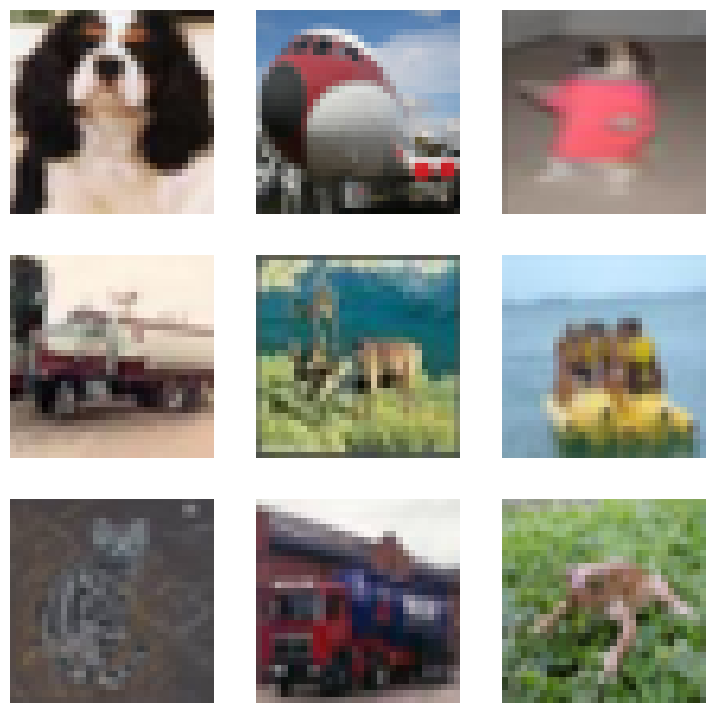

In [94]:
plt.figure(figsize=(9,9)) # dimensoes da imagem
randSamples = np.random.choice(50000, 9) # Escolhe nove aleatórios
for i in range(9): # Percorre os escolhidos e plot
    plt.subplot(3,3,i+1)
    plt.imshow(x_train[randSamples[i]], cmap='gray')
    plt.axis('off')

In [95]:
# Como o problema não é de classificação, e sim de generação foi juntado novamente a base de dadso
dataset = np.concatenate((x_train, x_test), axis=0)
dataset = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in dataset])
dataset = np.expand_dims(dataset, -1)  # Adiciona a dimensão do canal
dataset= dataset.astype("float32") / 255.0  # Normalização

In [96]:
# Criação de uma camada de sampling
class SamplingLayer(layers.Layer):
  """Reparameterization Trick z = mu + sigma * epsilon"""

  def call(self, inputs):
    zMean, zLogVar = inputs
    batch = tf.shape(zMean)[0]
    dim = tf.shape(zMean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return zMean + tf.exp(0.5 * zLogVar) * epsilon

In [97]:
#encoder
def buildEncoder(latentDim, encoderInputs):

  # Bloco que vai extrair as caracteristicas
  l1 = keras.models.Sequential([
    layers.Conv2D(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2D(64, 3, activation="relu", strides=2, padding="same"),
    layers.Flatten(),
    layers.Dense(256, activation="relu")
  ])
  # passa as entradas pelo bloco convolucional
  x = l1(encoderInputs)
  # calculo da media
  zMean = layers.Dense(latentDim, name="z_mean")(x)
  # calculo da variancia
  zLogVar = layers.Dense(latentDim, name="z_log_var")(x)
  # aplicação da reparametrização
  z = SamplingLayer()([zMean, zLogVar])

  # retonra o modelo
  return keras.Model(encoderInputs, [zMean, zLogVar, z], name="encoder")


# constroi o modelo
encoderInputs = keras.Input(shape=(32, 32, 1))
encoder = buildEncoder(2, encoderInputs)
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 32, 32, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sequential_12             │ (None, 256)            │      1,123,904 │ input_layer_24[0][0]   │
│ (Sequential)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │            514 │ sequential_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │            514 │ sequential_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling_layer_5          │ (None, 2)              │              0 │ z_mean[0][0],          │
│ (SamplingLayer)           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,124,932 (4.29 MB)

 Trainable params: 1,124,932 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [98]:
# decoder
def buildDecoder(latentInputs):
  # bloco que vai reconstruir as caracteristicas
  l1 = keras.models.Sequential([
    layers.Dense(8*8*64, activation="relu", input_shape=(latentInputs.shape[1],)),
    layers.Reshape((8,8,64)),
    layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same"),
    layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")
  ])
  # Retorna o modelo
  return keras.Model(latentInputs, l1(latentInputs), name="decoder")

# constroi o modelo
latentInputs = keras.Input(shape=(2,))
decoder = buildDecoder(latentInputs)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_26 (InputLayer)          │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_13 (Sequential)           │ (None, 32, 32, 1)           │         160,513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,513 (627.00 KB)

 Trainable params: 160,513 (627.00 KB)

 Non-trainable params: 0 (0.00 B)

In [99]:
# Função loss
def reconstructionLoss(data, reconstructed):
  return tf.reduce_mean(
      tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstructed),axis=(1, 2))
  )

In [100]:
# Outra função loss
def klDivergenceLoss(zMean, zLogVar):
  return tf.reduce_mean(
      tf.reduce_sum(-0.5 * (1 + zLogVar - tf.square(zMean) - tf.exp(zLogVar)),axis=1)
  )

In [101]:
# Caclula a loss total, não pode haver duas
def calcTotalLoss(data, reconstructed, zMean, zLogVar):
  loss1 = reconstructionLoss(data, reconstructed)
  loss2 = klDivergenceLoss(zMean, zLogVar)
  klWeight = 3.0
  return  loss1, loss2, loss1 + klWeight * loss2

In [102]:
# Criação de um modelo VAE
class VAE(keras.Model):
  def __init__(self, encoder, decoder, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    # registra todas as loss para visualizar depois
    self.totalLossTracker = keras.metrics.Mean(name="total_loss")
    self.ceLossTracker = keras.metrics.Mean(name="ce_loss")
    self.klLossTracker = keras.metrics.Mean(name="kl_loss")

  # metricas para visualização
  @property
  def metrics(self):
    return [
        self.totalLossTracker,
        self.ceLossTracker,
        self.klLossTracker
    ]

  # claculo do gradiente + loss + pesos
  def train_step(self, data):
    # recordação de todos os gradientes
    with tf.GradientTape() as tape:
        # segue
        zMean, zLogVar, z = self.encoder(data)
        reconstruction = self.decoder(z)
        ceLoss, klLoss, totalLoss = calcTotalLoss(data, reconstruction, zMean, zLogVar)
    # retorna
    grads = tape.gradient(totalLoss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

    # atualiza a loss
    self.totalLossTracker.update_state(totalLoss)
    self.ceLossTracker.update_state(ceLoss)
    self.klLossTracker.update_state(klLoss)

    # rertorna a loss
    return {
        "total_loss": self.totalLossTracker.result(),
        "ce_loss": self.ceLossTracker.result(),
        "kl_loss": self.klLossTracker.result()
    }

In [103]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001)) # Compilação
history = vae.fit(dataset, epochs=32, batch_size=128) # Treinamento com 32 epocas

Epoch 1/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 21ms/step - ce_loss: 688.2726 - kl_loss: 1.3746 - total_loss: 692.3962
Epoch 2/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - ce_loss: 657.5179 - kl_loss: 2.8447 - total_loss: 666.0518
Epoch 3/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step - ce_loss: 657.0797 - kl_loss: 2.8448 - total_loss: 665.6140
Epoch 4/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - ce_loss: 656.8936 - kl_loss: 2.8409 - total_loss: 665.4161
Epoch 5/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - ce_loss: 656.7411 - kl_loss: 2.8640 - total_loss: 665.3331
Epoch 6/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 656.6793 - kl_loss: 2.8602 - total_loss: 665.2597
Epoch 7/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 656.5635 - kl_loss: 2.8655 - total_loss: 665.1599
Epoch 8/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - ce_loss: 656.4705 - kl_loss: 2.8728 - total_loss: 665.0889
Epoch 9/32
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - ce_loss: 656.3386 - kl_loss: 2

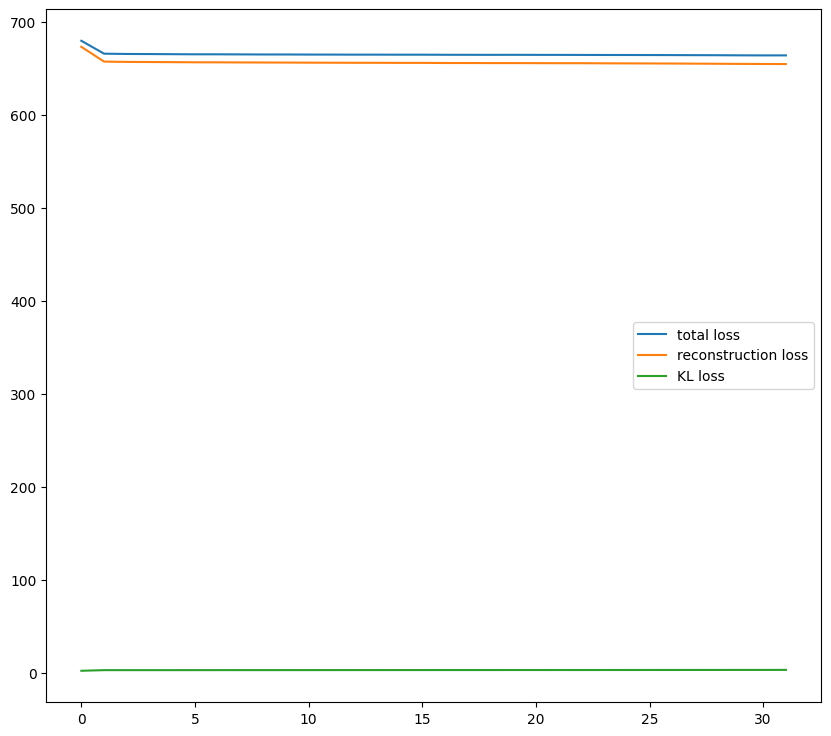

In [104]:
# Plotando o historico da loss
plt.figure(figsize=(10, 9))
plt.plot(history.history.get('total_loss'), label="total loss")
plt.plot(history.history.get('ce_loss'), label="reconstruction loss")
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

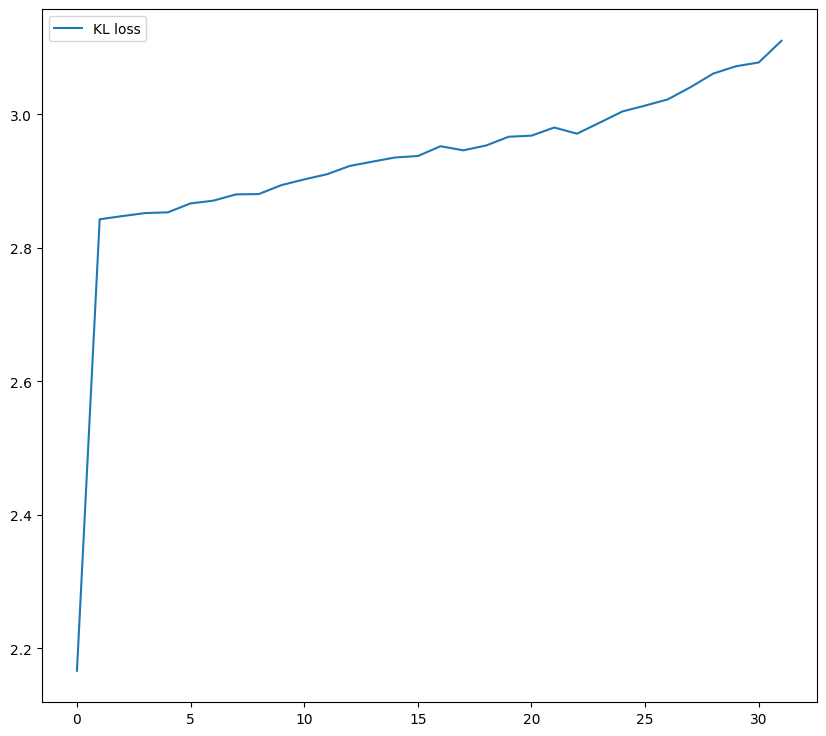

In [105]:
# Plotando só a kl_loss
plt.figure(figsize=(10,9))
plt.plot(history.history.get('kl_loss'), label="KL loss")
plt.legend();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step


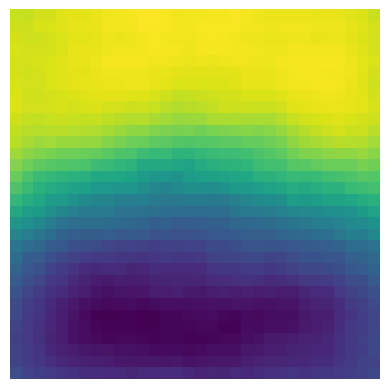

In [107]:
synth = vae.decoder.predict(np.array([[1, 2]])) # Gera uma imagem
plt.axis('off')
plt.imshow(synth.reshape((32,32))); # mostra a imagem gerada

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


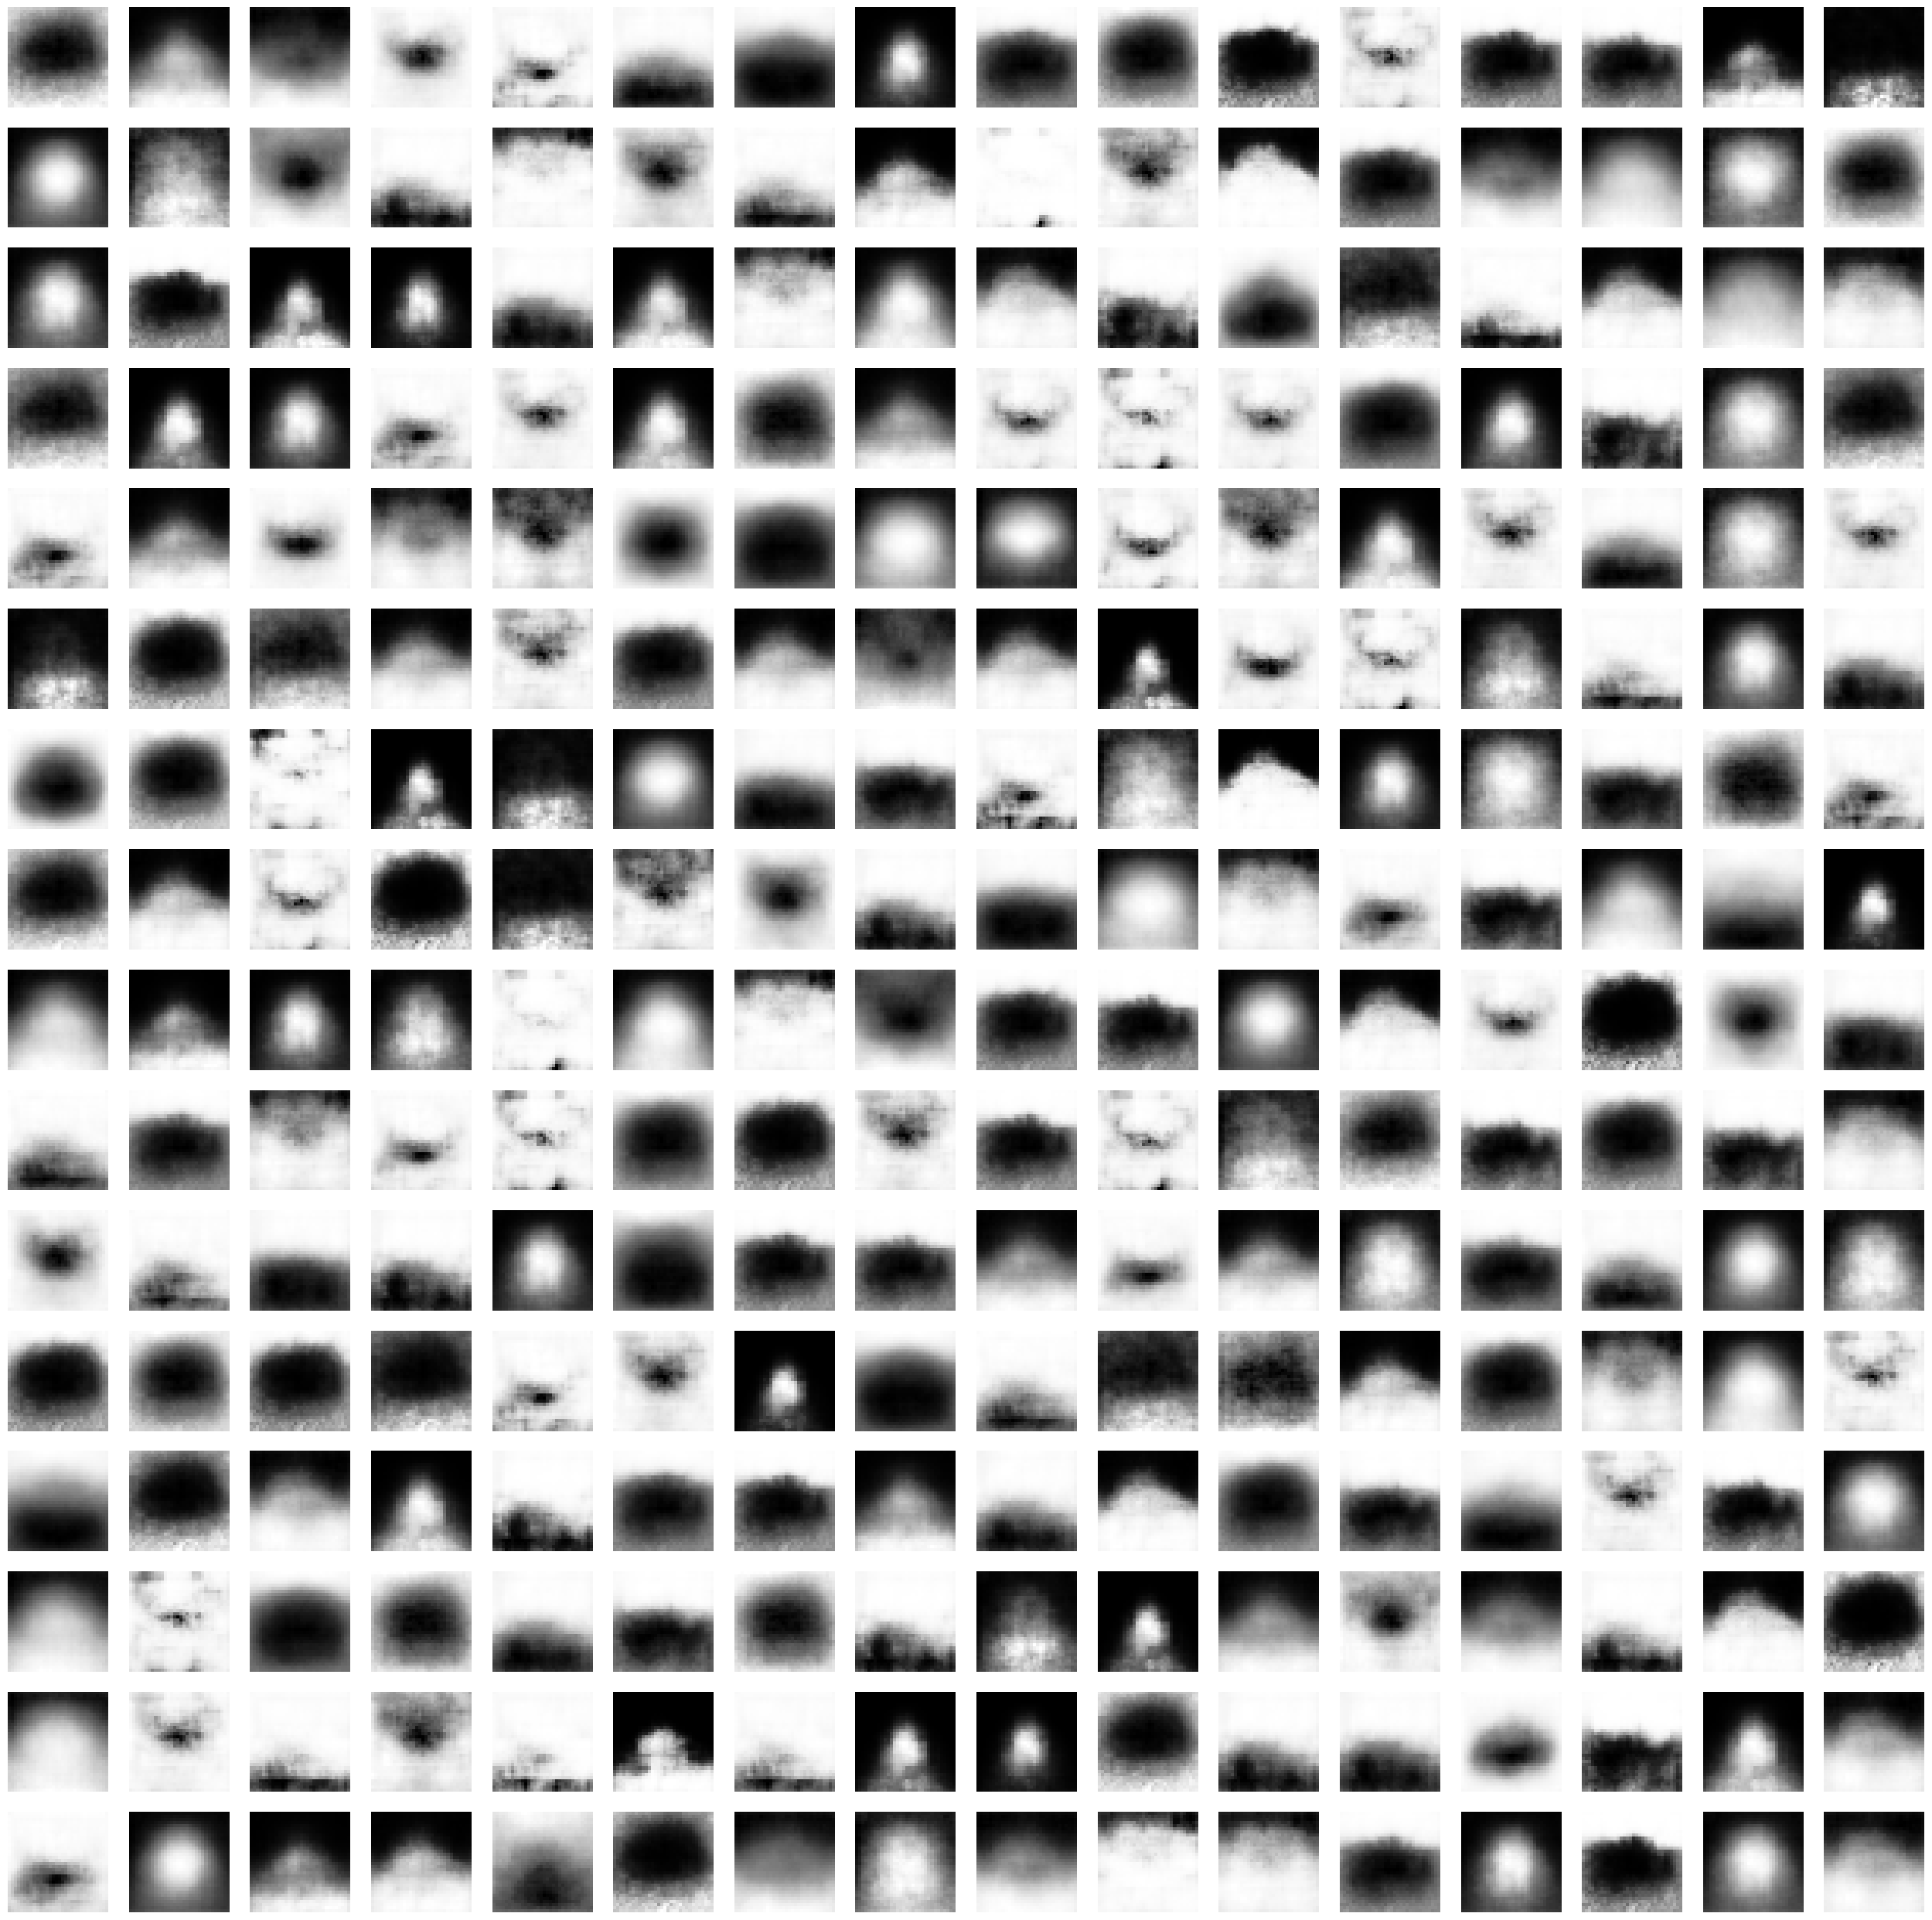

In [110]:
z = np.random.normal(loc=0, scale=4, size=(256,2)) # escolha de 256 aleatórios
synth = vae.decoder.predict(z) # Geração desses 256
plt.figure(figsize=(32,32)) # Tamanho da imagem
for i in range(256): # plotando as 256
    plt.subplot(16,16,i+1)
    plt.imshow(synth[i].reshape((32,32)), cmap="Greys_r")
    plt.axis('off')
plt.show();

In [125]:
idx = 0  # imagem aleatória número 1280 para geração de um tipo específico de roupa
batch = np.expand_dims(x_train[idx], axis=0)
# Convert batch to grayscale
batch = np.array([cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in batch])
batchOfImages = np.expand_dims(batch, axis=-1).astype("float32") / 255  # normalização
print(batchOfImages.shape)
_, _, z = vae.encoder.predict(batchOfImages)
# reconstroi uma imagem similar
synth = vae.decoder.predict([z])

z

(1, 32, 32, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([[-0.04570323, -0.78620654]], dtype=float32)

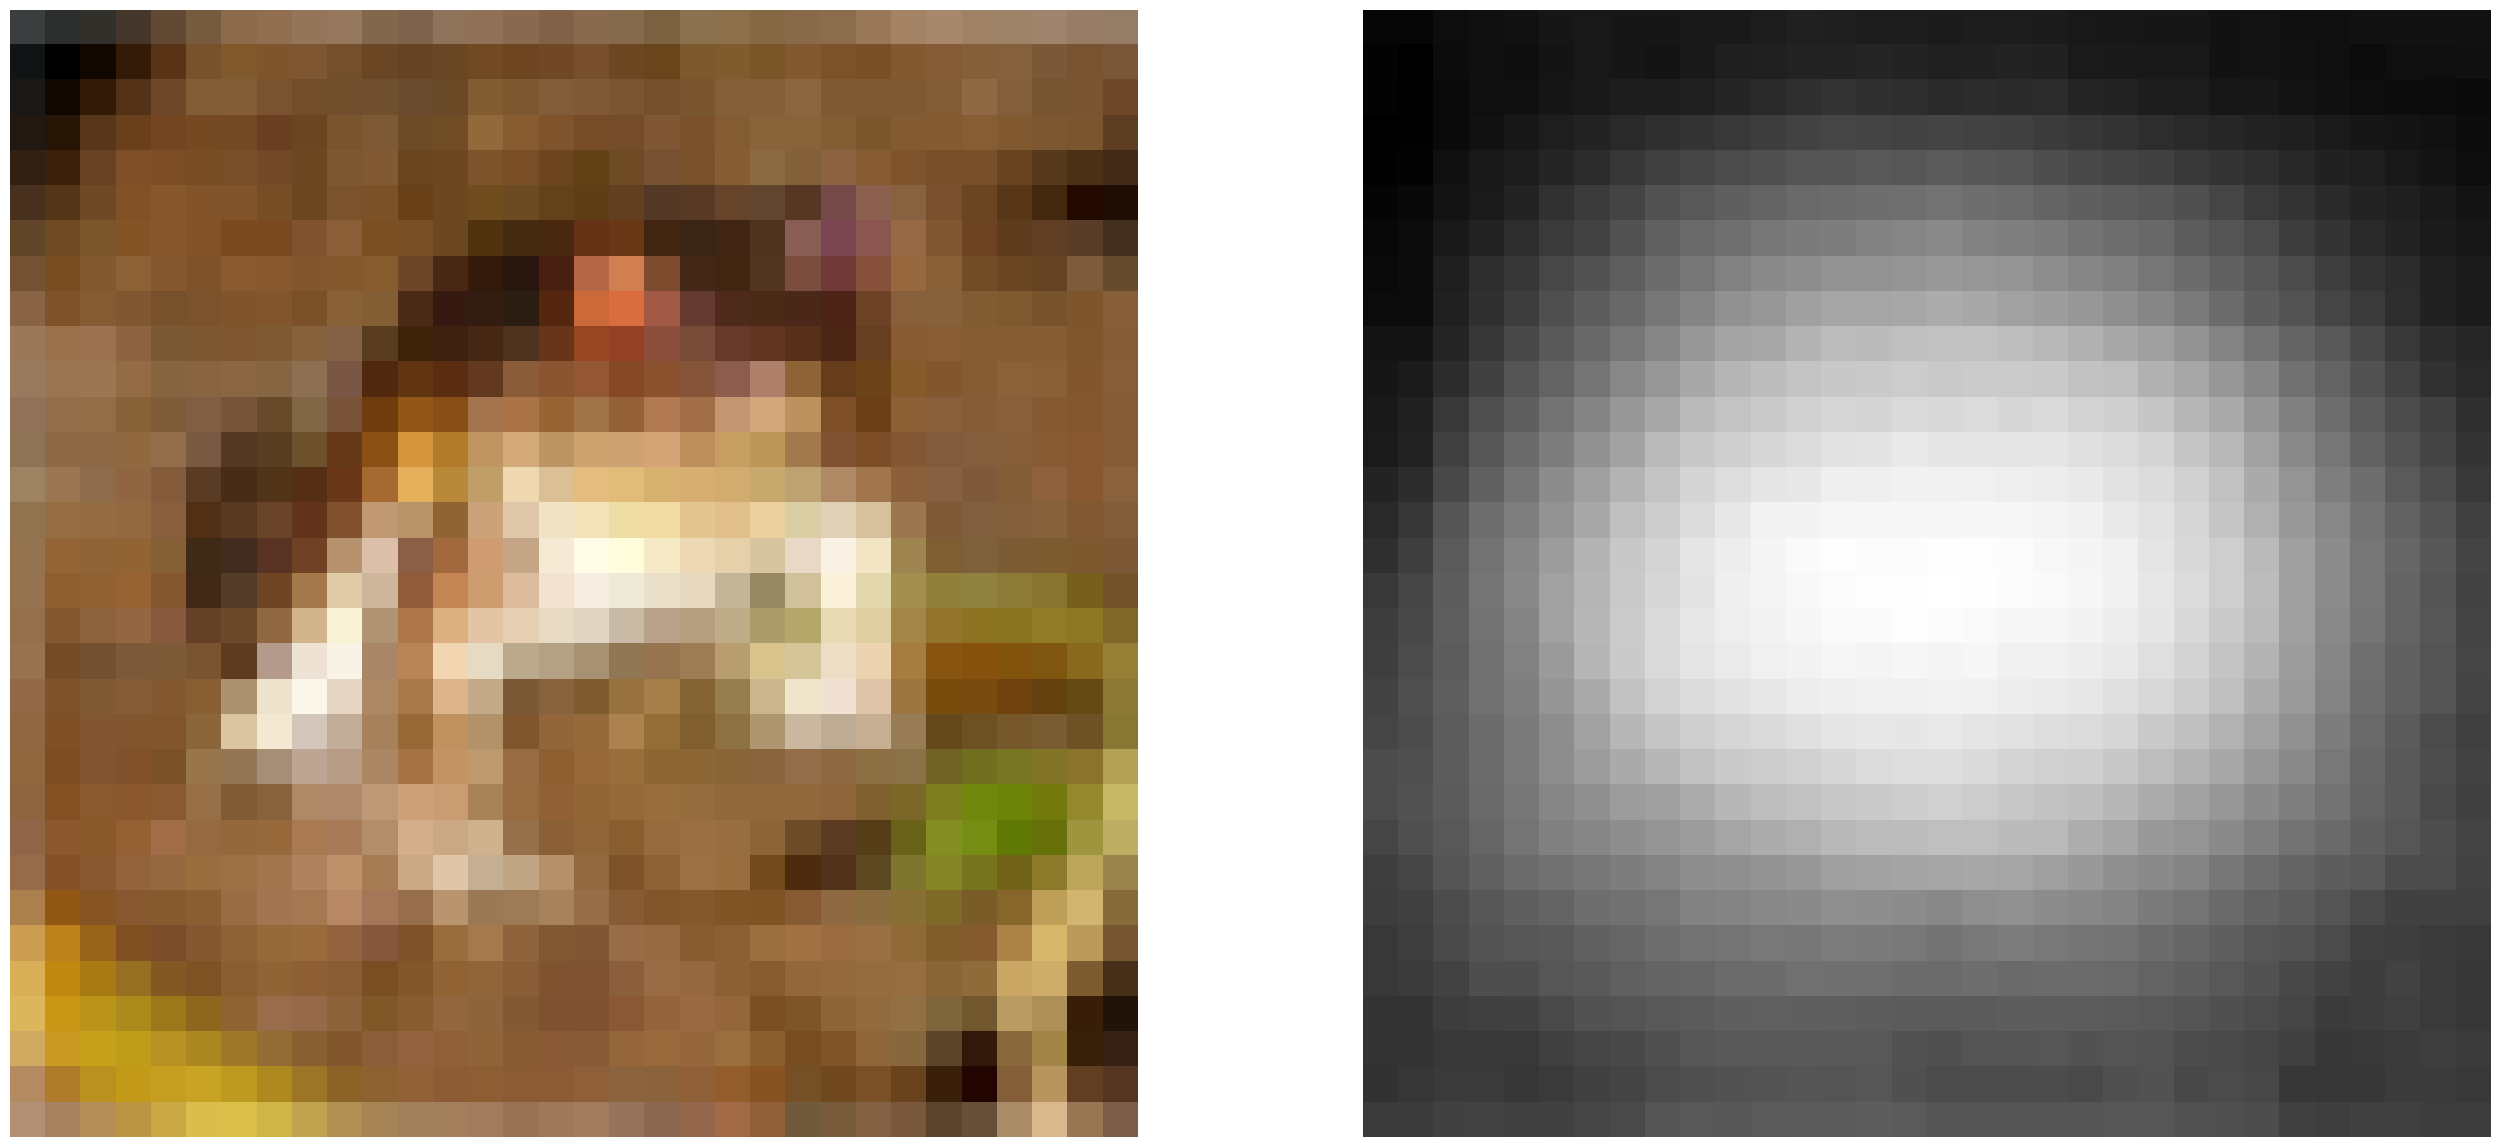

In [126]:
plt.figure(figsize=(32, 32))

# mostra a imagem original
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(x_train[idx], cmap="Greys_r")


# mostra a imagem gerada
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(synth[0].reshape((32,32)), cmap="Greys_r")
plt.show();

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


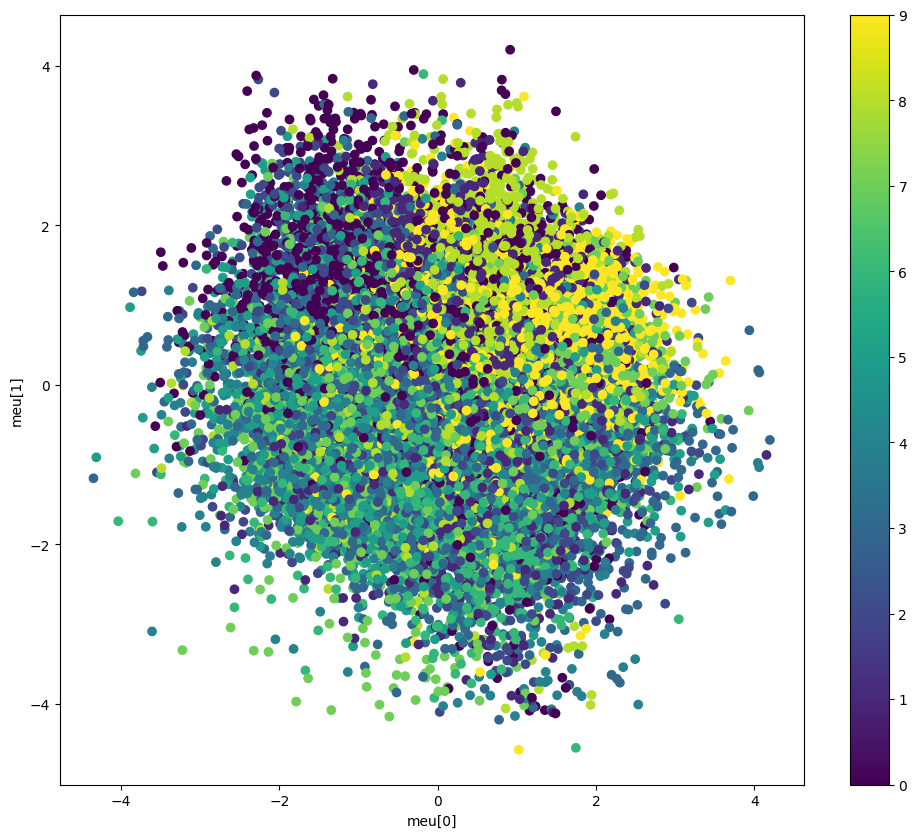

In [122]:
"""
VAE can be used in unsupervised learning of large text or unlabeled images corpus
to cluster the samples into categories
"""
# Plotando a distribuições de probabilidade
labels = np.concatenate([y_train, y_test], axis=0)
meu, _, _ = vae.encoder.predict(dataset)
plt.figure(figsize=(12, 10))
plt.scatter(meu[:, 0], meu[:, 1], c=labels)
plt.colorbar()
plt.xlabel("meu[0]")
plt.ylabel("meu[1]")
plt.show();